<a href="https://colab.research.google.com/github/arhana-k/BrainTumor_Segmentation/blob/main/Arhana_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,concatenate,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
import keras.backend as K
import seaborn as sns
import shutil

In [2]:
#define the input size that the U-net model expects
IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

In [3]:
#download the kaggle dataset
!kaggle datasets download nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown
100% 311M/312M [00:16<00:00, 23.3MB/s]
100% 312M/312M [00:16<00:00, 20.4MB/s]


The dataset will be downloaded in zip format. Unzip it.

In [4]:
!unzip brain-tumor-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/2013.png         
  inflating: images/2014.png         
  inflating: images/2015.png         
  inflating: images/2016.png         
  inflating: images/2017.png         
  inflating: images/2018.png         
  inflating: images/2019.png         
  inflating: images/202.png          
  inflating: images/2020.png         
  inflating: images/2021.png         
  inflating: images/2022.png         
  inflating: images/2023.png         
  inflating: images/2024.png         
  inflating: images/2025.png         
  inflating: images/2026.png         
  inflating: images/2027.png         
  inflating: images/2028.png         
  inflating: images/2029.png         
  inflating: images/203.png          
  inflating: images/2030.png         
  inflating: images/2031.png         
  inflating: images/2032.png         
  inflating: images/2033.png         
  inflating: images/2034.png         
  inflating: images/2035.png         

In [5]:
#load and initialize data for training the model
Original=os.listdir('images')
Masks=os.listdir('masks')
# Original = Original
# Masks = Masks

#verify if the number of images and masks matches
print(len(Original))
print(len(Masks))

3064
3064


In [6]:
#initialize data arrays
X=np.zeros((len(Original),IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS), dtype=np.float32)
y=np.zeros((len(Masks),IMG_HEIGHT,IMG_WIDTH,1), dtype=np.int32)
#the masks represent a binary classification (tumor or non-tumor) for each pixel, and a single channel suffices.
print(X.shape)
print(y.shape)

(3064, 256, 256, 3)
(3064, 256, 256, 1)


In [7]:
#iterate through the image filenames
for file in Original:
    #build image path
    n=Original.index(file)
    path1=os.path.join('/content/images',file)
    print(path1)
    #Load and Preprocess Image:
    img=cv2.imread(path1)
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    #Load and Preprocess Mask
    try:
        X[n]=img/255
        file2=Masks[n]
        path2=os.path.join('/content/masks',file2)
        mask=cv2.imread(path2,cv2.IMREAD_GRAYSCALE)
        mask=cv2.resize(mask,(256,256))
        mask = tf.one_hot(mask, 1, dtype=tf.int32)
        y[n] = mask
    #error handling
    except Exception as e:
        print(e)
        print(path1)

/content/images/1828.png
/content/images/2596.png
/content/images/828.png
/content/images/1152.png
/content/images/2354.png
/content/images/25.png
/content/images/110.png
/content/images/11.png
/content/images/1321.png
/content/images/1604.png
/content/images/2426.png
/content/images/1760.png
/content/images/1495.png
/content/images/1759.png
/content/images/682.png
/content/images/2253.png
/content/images/2750.png
/content/images/1186.png
/content/images/1068.png
/content/images/2848.png
/content/images/890.png
/content/images/1272.png
/content/images/2948.png
/content/images/1407.png
/content/images/2366.png
/content/images/783.png
/content/images/1218.png
/content/images/551.png
/content/images/2493.png
/content/images/396.png
/content/images/204.png
/content/images/627.png
/content/images/3030.png
/content/images/3044.png
/content/images/1701.png
/content/images/1271.png
/content/images/621.png
/content/images/907.png
/content/images/1743.png
/content/images/973.png
/content/images/

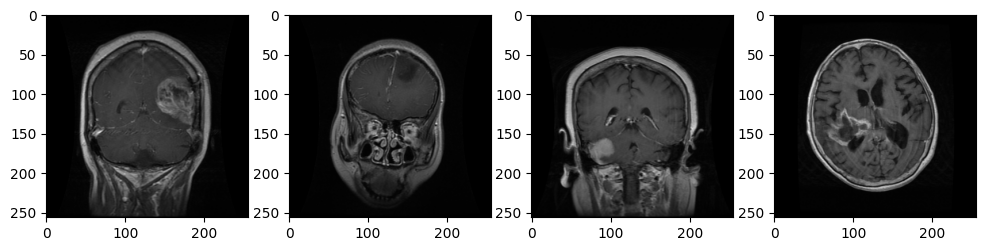

In [8]:
#visualize a random sample of images from the loaded dataset X
i = np.random.randint(1, 1000)
plt.figure(figsize = (12,15))
plt.subplot(141)
plt.imshow(X[i])

plt.subplot(142)
plt.imshow(X[i+1])

plt.subplot(143)
plt.imshow(X[i+2])

plt.subplot(144)
plt.imshow(X[i+3])

In [9]:
#create a new reference to the same underlying data
images = X
print(images.shape)

masks = y
masks.shape

(3064, 256, 256, 3)


(3064, 256, 256, 1)

In [10]:
#split the data for training(80%) and testing(20%)
X_train,X_test,y_train,y_test=train_test_split(images,masks,test_size=0.2,random_state=42)

In [11]:
inputs=tf.keras.layers.Input((256,256,3)) #define input layer

s = inputs

#Contraction path of the U-net
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.2)(c1)  #to tackle overfitting
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1) #Downsample the input along its spatial dimensions by taking the maximum value over an input window (of size defined by pool_size ) for each channel of the input.

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.2)(c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5) #upsample
u6 = concatenate([u6, c4]) #merges the upsampled features with the corresponding feature map
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.2)(c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.2)(c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1,(1, 1),activation='sigmoid')(c9) #output layer of the U-net
#create a Keras model object
model = Model(inputs=[inputs], outputs=[outputs])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [13]:
#compile the U-net model, specifying the optimizer (here Adam optimizer), loss function, and metrics for training.
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss='binary_crossentropy', metrics=['accuracy'],
              )

In [14]:
#train the model using the fit method
history=model.fit(X_train, y_train,validation_data = (X_test,y_test),
                  epochs=18, batch_size=8
                  )

Epoch 1/18
307/307 [==============================] - 58s 128ms/step - loss: 0.0784 - accuracy: 0.9821 - val_loss: 0.0746 - val_accuracy: 0.9822
Epoch 2/18
307/307 [==============================] - 30s 99ms/step - loss: 0.0577 - accuracy: 0.9826 - val_loss: 0.0713 - val_accuracy: 0.9822
Epoch 3/18
307/307 [==============================] - 32s 103ms/step - loss: 0.0514 - accuracy: 0.9826 - val_loss: 0.0537 - val_accuracy: 0.9822
Epoch 4/18
307/307 [==============================] - 31s 102ms/step - loss: 0.0473 - accuracy: 0.9835 - val_loss: 0.0552 - val_accuracy: 0.9852
Epoch 5/18
307/307 [==============================] - 31s 102ms/step - loss: 0.0405 - accuracy: 0.9868 - val_loss: 0.0394 - val_accuracy: 0.9859
Epoch 6/18
307/307 [==============================] - 30s 98ms/step - loss: 0.0345 - accuracy: 0.9884 - val_loss: 0.0356 - val_accuracy: 0.9883
Epoch 7/18
307/307 [==============================] - 30s 98ms/step - loss: 0.0308 - accuracy: 0.9893 - val_loss: 0.0290 - val_accur

<ipython-input-15-bde774d65790>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'b', color='green',label='Validation acc')


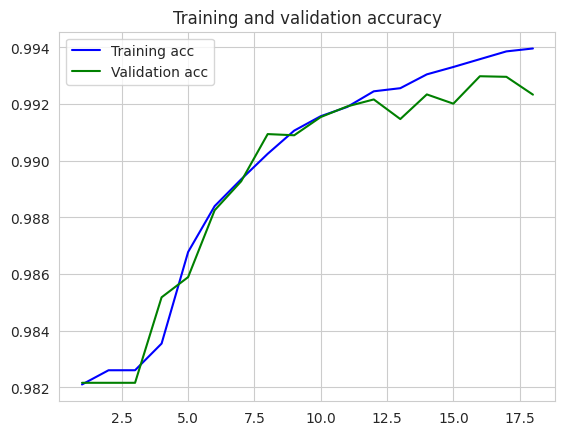

In [15]:
#visualize the training and validation accuracy curves of the U-net model
sns.set_style('whitegrid')
#extract data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1) #used as x-axis for the plot
#plotting accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', color='green',label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

<ipython-input-16-0874bfccb9ed>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', color = 'green', label='Validation loss')


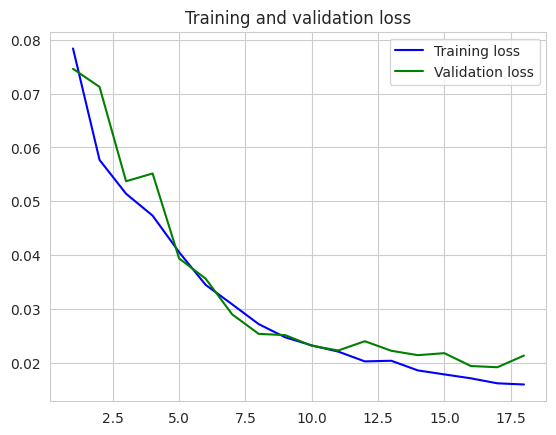

In [16]:
#create a plot visualizing the training and validation loss curves of the U-net model after training
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', color = 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
def predict_image(img_path, mask_path, model):
    #image preprocessing
    H = 256
    W = 256
    num_classes = 1

    img = cv2.imread(img_path)
    img = img[:256, :256, :]
    img = img / 255.0
    img = img.astype(np.float32)


    # Prediction
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    #process the predicted mask
    pred_mask = pred_mask[0]


    # calculating IOU(Intersection over Union) score
    inter = np.logical_and(mask, pred_mask)
    union = np.logical_or(mask, pred_mask)

    iou = inter.sum() / union.sum()

    return img, mask, pred_mask, iou

1/1 [==============================] - 2s 2s/step


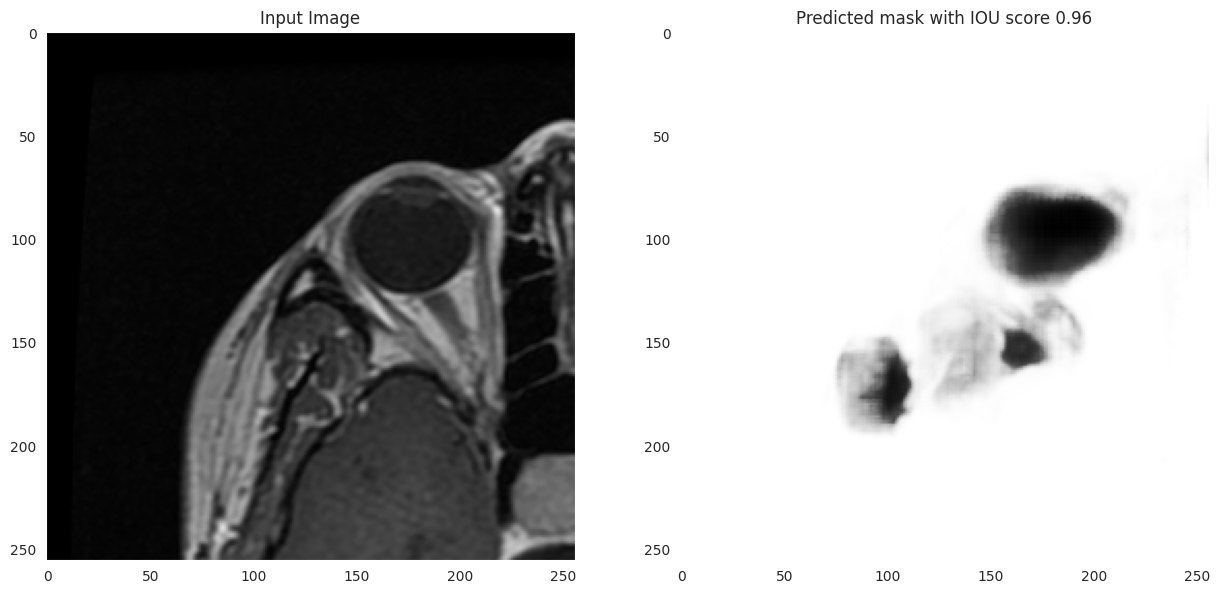

In [18]:
sns.set_style('dark')
#define path
img_path = '/content/images/1000.png'
mask_path = '/content/masks/1000.png'

img, mask, pred_mask, iou = predict_image(img_path, mask_path, model)

#create subplots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 10))

#plot image and mask
ax1.set_title("Input Image")
ax1.imshow(img)

ax2.set_title("Predicted mask with IOU score %.2f"%(iou))
ax2.imshow(pred_mask, cmap='gray')

#display the generated figure containing the subplots with the image, predicted mask, and IoU score.
plt.show()